In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nslkdd/kdd_train.csv
/kaggle/input/nslkdd/kdd_test.csv


# import modules

In [53]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

In [54]:
def getRanges(data):
    ranges={}
    for c in data.columns:
        if data[c].dtype=='int64' or data[c].dtype=='float64':
            ranges[c]=(data[c].max()-data[c].min())
    return ranges

def getCategoricalValues(data):
    categoricalVals={}
    for c in data.columns:
        if data[c].dtype=='object':
            categoricalVals[c]=data[c].unique()
            print(f'{c} : {sorted(list(data[c].unique()))} \n count = {len(list(data[c].unique()))} \n')
    return categoricalVals

# import dataset

In [55]:
dfTrain=pd.read_csv('../input/nslkdd/kdd_train.csv')
dtTrain=dfTrain.copy()
dfTest=pd.read_csv('../input/nslkdd/kdd_test.csv')
dtTest=dfTest.copy()

# Exploring Dataset

In [56]:
dtTrain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [57]:
dtTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [58]:
dtTrain.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [59]:
getRanges(dtTrain)

{'duration': 42908,
 'src_bytes': 1379963888,
 'dst_bytes': 1309937401,
 'land': 1,
 'wrong_fragment': 3,
 'urgent': 3,
 'hot': 77,
 'num_failed_logins': 5,
 'logged_in': 1,
 'num_compromised': 7479,
 'root_shell': 1,
 'su_attempted': 2,
 'num_root': 7468,
 'num_file_creations': 43,
 'num_shells': 2,
 'num_access_files': 9,
 'num_outbound_cmds': 0,
 'is_host_login': 1,
 'is_guest_login': 1,
 'count': 511,
 'srv_count': 511,
 'serror_rate': 1.0,
 'srv_serror_rate': 1.0,
 'rerror_rate': 1.0,
 'srv_rerror_rate': 1.0,
 'same_srv_rate': 1.0,
 'diff_srv_rate': 1.0,
 'srv_diff_host_rate': 1.0,
 'dst_host_count': 255,
 'dst_host_srv_count': 255,
 'dst_host_same_srv_rate': 1.0,
 'dst_host_diff_srv_rate': 1.0,
 'dst_host_same_src_port_rate': 1.0,
 'dst_host_srv_diff_host_rate': 1.0,
 'dst_host_serror_rate': 1.0,
 'dst_host_srv_serror_rate': 1.0,
 'dst_host_rerror_rate': 1.0,
 'dst_host_srv_rerror_rate': 1.0}

# Test data

In [60]:
dtTest.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,tcp,smtp,SF,2429,475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,180,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,normal
1,0,udp,domain_u,SF,45,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,192,269,0.0,0.0,0.0,0.0,0.99,0.01,0.01,194,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,normal
2,0,udp,domain_u,SF,45,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,121,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,normal
3,1979,udp,other,SF,145,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,normal
4,14462,tcp,other,RSTR,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.0,1.0,1.00,0.00,0.00,255,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,portsweep


In [61]:
dtTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [62]:
dtTest.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [63]:
getRanges(dtTest)

{'duration': 54451,
 'src_bytes': 62825648,
 'dst_bytes': 5153771,
 'land': 1,
 'wrong_fragment': 3,
 'urgent': 2,
 'hot': 30,
 'num_failed_logins': 5,
 'logged_in': 1,
 'num_compromised': 796,
 'root_shell': 1,
 'su_attempted': 2,
 'num_root': 878,
 'num_file_creations': 43,
 'num_shells': 2,
 'num_access_files': 8,
 'num_outbound_cmds': 0,
 'is_host_login': 1,
 'is_guest_login': 1,
 'count': 511,
 'srv_count': 511,
 'serror_rate': 1.0,
 'srv_serror_rate': 1.0,
 'rerror_rate': 1.0,
 'srv_rerror_rate': 1.0,
 'same_srv_rate': 1.0,
 'diff_srv_rate': 1.0,
 'srv_diff_host_rate': 1.0,
 'dst_host_count': 254,
 'dst_host_srv_count': 254,
 'dst_host_same_srv_rate': 1.0,
 'dst_host_diff_srv_rate': 1.0,
 'dst_host_same_src_port_rate': 1.0,
 'dst_host_srv_diff_host_rate': 1.0,
 'dst_host_serror_rate': 1.0,
 'dst_host_srv_serror_rate': 1.0,
 'dst_host_rerror_rate': 1.0,
 'dst_host_srv_rerror_rate': 1.0}

In [64]:
getCategoricalValues(dtTrain)
print('TRAIN DATA')

protocol_type : ['icmp', 'tcp', 'udp'] 
 count = 3 

service : ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'] 
 count = 70 

flag : ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'] 
 count = 11 

labels : ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'nor

In [65]:
getCategoricalValues(dtTest)
print('TEST DATA')

protocol_type : ['icmp', 'tcp', 'udp'] 
 count = 3 

service : ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames', 'http', 'http_443', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'] 
 count = 66 

flag : ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'] 
 count = 11 

labels : ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nma

# Encoding

In [66]:
valuesToEncode=getCategoricalValues(dtTrain)
valuesToEncode.pop('labels')
items=getCategoricalValues(dtTest)
items['labels']=np.append(items['labels'],'spy')
items.pop('protocol_type')
items.pop('service')
items.pop('flag')
valuesToEncode.update(items)

protocol_type : ['icmp', 'tcp', 'udp'] 
 count = 3 

service : ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'] 
 count = 70 

flag : ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'] 
 count = 11 

labels : ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'nor

In [67]:
valuesToEncode

{'protocol_type': array(['tcp', 'udp', 'icmp'], dtype=object),
 'service': array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
        'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
        'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
        'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
        'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
        'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
        'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
        'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
        'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
        'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
        'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object),
 'flag': array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
        'S2', 'OTH'], dtype=object),
 'labels': array(['normal'

In [68]:
def encodeData(data):
    data['protocol_type'].replace(valuesToEncode['protocol_type'],[1,2,3], inplace=True)
    data['service'].replace(valuesToEncode['service'],list(range(1, 71)), inplace=True)
    data['flag'].replace(valuesToEncode['flag'],list(range(1, 12)), inplace=True)

In [69]:
encodeData(dtTrain)
dtTrain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,1,1,1,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,2,2,1,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,1,4,1,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,1,4,1,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [70]:
encodeData(dtTest)
dtTest.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,1,16,1,2429,475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,180,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,normal
1,0,2,12,1,45,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,192,269,0.0,0.0,0.0,0.0,0.99,0.01,0.01,194,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,normal
2,0,2,12,1,45,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,121,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,normal
3,1979,2,2,1,145,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,normal
4,14462,1,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.0,1.0,1.00,0.00,0.00,255,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,portsweep


# Modeling (linear Kernel SVC):

In [71]:
x = dtTrain.drop(['labels'],axis=1)
y = dtTrain['labels']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [72]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', degree=5))
clf.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(degree=5, kernel='linear'))])

In [73]:
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.9879140288555042
0.9865052589799563


# Test Model

In [74]:
X_test = dtTest.drop(['labels'],axis=1)
Y_test = dtTest['labels']

In [75]:
Y_predict = clf.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

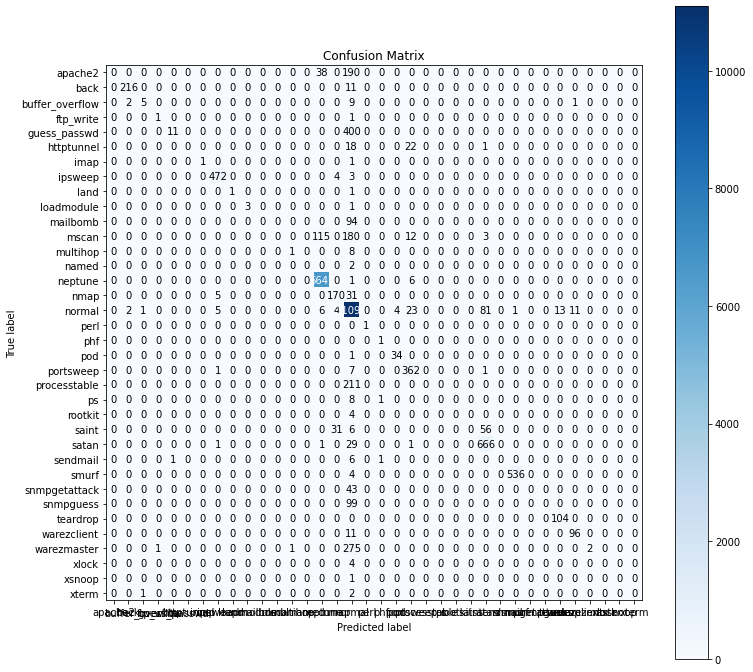

In [76]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(12,12))

In [77]:
print(classification_report(Y_test, Y_predict))

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.98      0.95      0.97       227
buffer_overflow       0.71      0.29      0.42        17
      ftp_write       0.50      0.50      0.50         2
   guess_passwd       0.92      0.03      0.05       411
     httptunnel       0.00      0.00      0.00        41
           imap       1.00      0.50      0.67         2
        ipsweep       0.98      0.99      0.98       479
           land       1.00      0.50      0.67         2
     loadmodule       1.00      0.75      0.86         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       0.50      0.11      0.18         9
          named       0.00      0.00      0.00         2
        neptune       0.98      1.00      0.99      6654
           nmap       0.81      0.83      0.82       206
         normal       0.87    

In [78]:
x = dtTrain.drop(['labels'],axis=1)
y = dtTrain['labels']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [79]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [80]:
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.9930044255690726
0.991387179996031


In [81]:
X_test = dtTest.drop(['labels'],axis=1)
Y_test = dtTest['labels']

In [82]:
Y_predict = clf.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

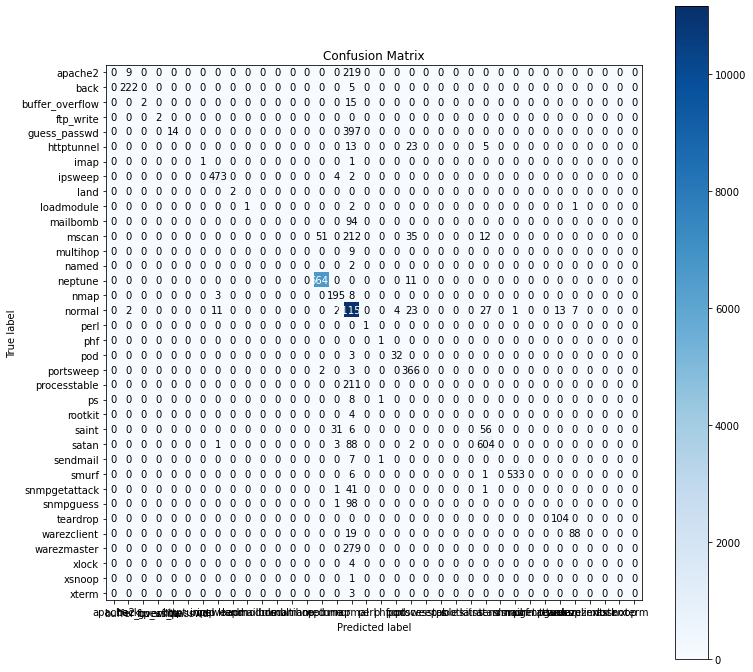

In [83]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(12,12))

In [84]:
print(classification_report(Y_test, Y_predict)) 

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.95      0.98      0.97       227
buffer_overflow       1.00      0.12      0.21        17
      ftp_write       1.00      1.00      1.00         2
   guess_passwd       1.00      0.03      0.07       411
     httptunnel       0.00      0.00      0.00        41
           imap       1.00      0.50      0.67         2
        ipsweep       0.97      0.99      0.98       479
           land       1.00      1.00      1.00         2
     loadmodule       1.00      0.25      0.40         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       0.00      0.00      0.00         9
          named       0.00      0.00      0.00         2
        neptune       0.99      1.00      1.00      6654
           nmap       0.82      0.95      0.88       206
         normal       0.86    

# Ploynomial Kernal Svc

In [85]:
x = dtTrain.drop(['labels'],axis=1)
y = dtTrain['labels']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [86]:
clf = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=5))
clf.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(degree=5, kernel='poly'))])

In [87]:
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.981533668062474
0.9795594363961103


In [88]:
X_test = dtTest.drop(['labels'],axis=1)
Y_test = dtTest['labels']

In [89]:
Y_predict = clf.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

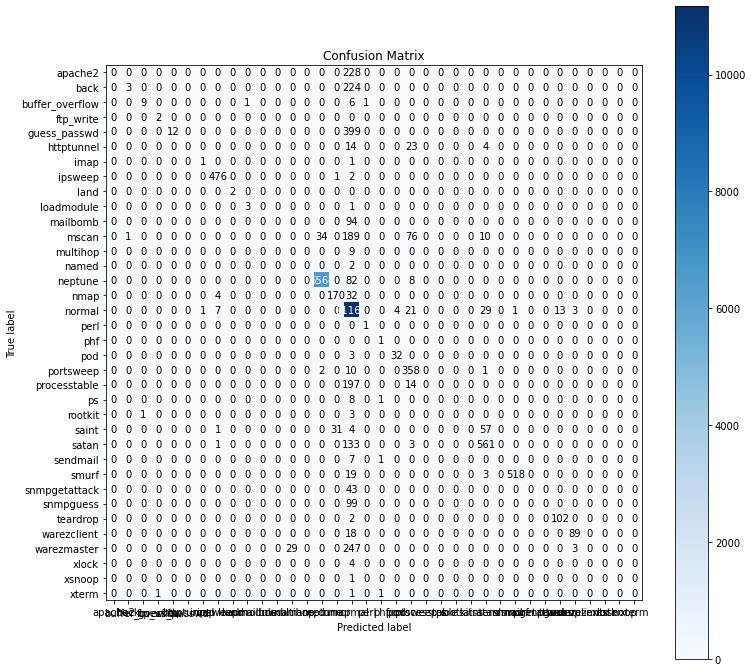

In [90]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(12,12))

In [91]:
print(classification_report(Y_test, Y_predict)) 

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.75      0.01      0.03       227
buffer_overflow       0.90      0.53      0.67        17
      ftp_write       0.67      1.00      0.80         2
   guess_passwd       1.00      0.03      0.06       411
     httptunnel       0.00      0.00      0.00        41
           imap       0.50      0.50      0.50         2
        ipsweep       0.97      0.99      0.98       479
           land       1.00      1.00      1.00         2
     loadmodule       0.75      0.75      0.75         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       0.00      0.00      0.00         9
          named       0.00      0.00      0.00         2
        neptune       0.99      0.99      0.99      6654
           nmap       0.84      0.83      0.83       206
         normal       0.84    

# Sigmoid Kernel SVC

In [92]:
x = dtTrain.drop(['labels'],axis=1)
y = dtTrain['labels']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [93]:
clf = make_pipeline(StandardScaler(), SVC(kernel='sigmoid',degree=5))
clf.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(degree=5, kernel='sigmoid'))])

In [94]:
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.8974776240846216


KeyboardInterrupt: 

In [ ]:
X_test = dtTest.drop(['labels'],axis=1)
Y_test = dtTest['labels']

In [ ]:
Y_predict = clf.predict(X_test)

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(12,12))

In [ ]:
print(classification_report(Y_test, Y_predict)) 

# Modeling (GridSearch):

In [115]:
x = dtTrain.drop(['labels'],axis=1)
y = dtTrain['labels']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.8, random_state=0)

In [116]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [117]:
params = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear','rbf','poly','sigmoid'],
              'degree':[3,5,7]} 

In [118]:
grid = GridSearchCV(SVC(),param_grid=params,cv=2,refit=True)

In [ ]:
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
X_test = dtTest.drop(['labels'],axis=1)
Y_test = dtTest['labels']

In [ ]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [ ]:
Y_predict = grid.predict(X_test) 

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

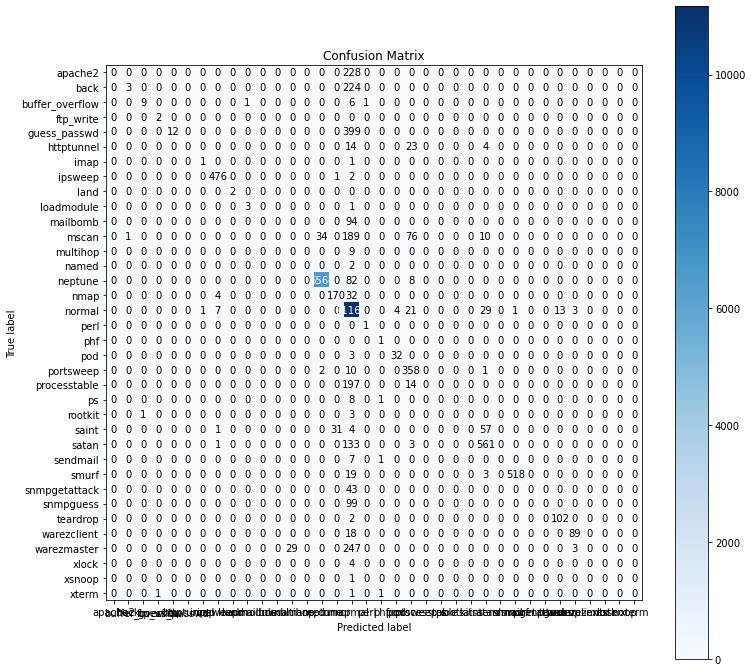

In [113]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(12,12))

In [114]:
print(classification_report(Y_test, Y_predict)) 

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.75      0.01      0.03       227
buffer_overflow       0.90      0.53      0.67        17
      ftp_write       0.67      1.00      0.80         2
   guess_passwd       1.00      0.03      0.06       411
     httptunnel       0.00      0.00      0.00        41
           imap       0.50      0.50      0.50         2
        ipsweep       0.97      0.99      0.98       479
           land       1.00      1.00      1.00         2
     loadmodule       0.75      0.75      0.75         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       0.00      0.00      0.00         9
          named       0.00      0.00      0.00         2
        neptune       0.99      0.99      0.99      6654
           nmap       0.84      0.83      0.83       206
         normal       0.84    